<h1 style="text-align:center">Spring-bar-cart Pendulum Example</h1>
<h3 style="text-align:center">MCHE 513: Intermediate Dynamics</h3> 
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

The system that you are modeling is shown in Figure 1. It consists of a thin beam of mass $m$ and length $R$ connected to a spring of stiffness $k$ via an ideal pin joint. The unstretched, equilibrium length of the spring is $L_0$. The other side of the spring is connected to cart of mass $M_t$ that can move horizontally without friction. Its position is described by $x$. There is a force, $f(t)$, that acts directly on this cart.

<p style="text-align:center">
	<img src="http://shared.crawlab.org/cart_spring_pendulum_bar.png" alt="Spring Pendulum from a Cart" width=35%><br>
    <strong>Figure 1: Spring Pendulum from a Cart</strong>
</p>

In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import inertia, LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame, RigidBody

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:
# Define the genearlized coordinate
x, R, theta1, theta2, f = dynamicsymbols('x R theta_1 theta_2 f')

# Also define the first derivative
x_dot, R_dot, theta1_dot, theta2_dot = dynamicsymbols('x R theta_1 theta_2', 1)

# Define the symbols for the other paramters
m, mt, g, k, l0, l, Izz, t = sympy.symbols('m mt g k L_0 l I_zz t')

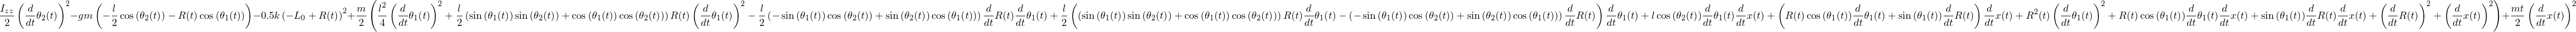

In [3]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frame along the spring, with y aligned from m to the pin
A = N.orientnew('A', 'Axis', [theta1, N.z])
B = N.orientnew('B', 'Axis', [theta2, N.z])

# Define an origin and set its velocity to 0
O = Point('0')
O.set_vel(N, 0 * N.x)

# Create the trolley - treat as a particle
T = O.locatenew('T', x * N.x)
T.set_vel(N, x_dot * N.x)

# Define the point at the end of the spring and set its velocity
P = T.locatenew('P', -R * A.y)
P.set_vel(N, x_dot * N.x + R * theta1_dot * A.x - R_dot * A.y)

# Define the COM of the bar location and velocity
G = P.locatenew('G', -l/2 * B.y)
G.v2pt_theory(P, N, A)

# Create the bar rigid bogy
I_bar = inertia(B, 0, 0, Izz)
bar = RigidBody('bar', G, B, m, (I_bar, G))

# Treat the trolley as a particle
mtr = Particle('mtr', T, mt)

# Now, set the potential energy of the bar
h = G.pos_from(T) & N.y # Define the height of the COM by the vertical distance from the datum
bar.set_potential_energy(m * g * h + 1/2 * k * (R - l0)**2)

# # Set up the force list - each item follows the form:
# #    (the location where the force is applied, its magnitude and direction)
# # Here, there are no non-conservataive external forces
forces = [(T, f * N.x)]

# # Form the Lagrangian
L =  Lagrangian(N, mtr, bar)

# # Print the Lagrangian as a check
L

In [4]:
# This creates a LagrangesMethod class instance that will 
# allow us to form the equations of motion, etc
LM = LagrangesMethod(L, [x, R, theta1, theta2], forcelist = forces, frame = N)

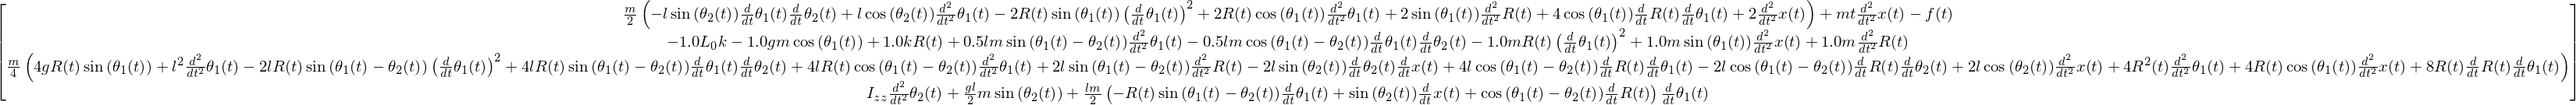

In [5]:
# Form the equations fo motion
EqMotion = LM.form_lagranges_equations()

# Print the simplified version of the equations of motion
sympy.simplify(EqMotion)

The <tt>LagrangesMethod</tt> class gives us lots of information about the system. For example, we can output the mass/inertia matrix and the forcing terms. Note that the forcing terms include what might be conservative forces and would therefore normally appear in a stiffness matrix.

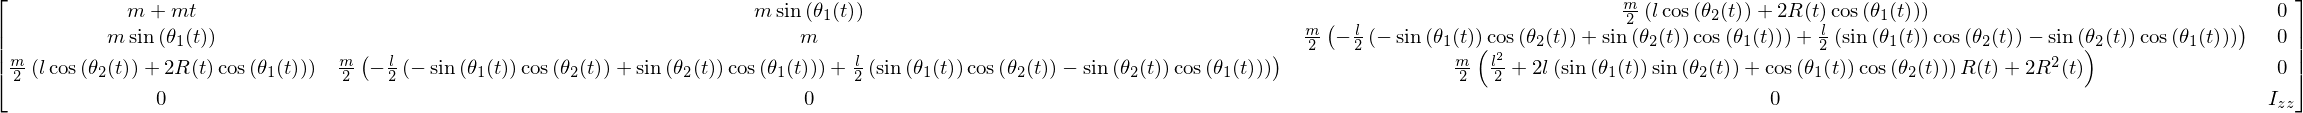

In [6]:
# Output the inertia/mass matrix of the system
LM.mass_matrix

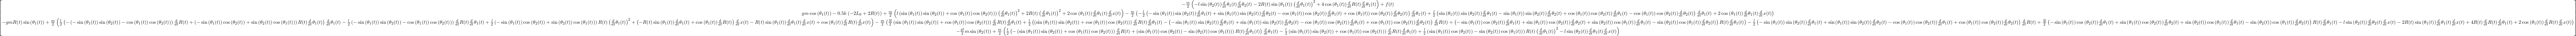

In [7]:
# Output the forcing terms of the system
LM.forcing

We can also use builtin functions to write the sytsem as a set of first order ODEs, suitable for simluation.

In [8]:
# This can be a very expensive call to make, if you don't need it

# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
#lrhs.simplify()

# Output the result
#lrhs

We can also linearize these equations with builtin SymPy methods. Let's do so about the $\theta = 0$, $\dot{\theta} = 0$ operating point. The resulting equations returned are a system of first order ODEs in state-space form:

$$ \dot{x} = Ax + Bu $$

See the [SymPy Documentation](http://docs.sympy.org/0.7.6/modules/physics/mechanics/linearize.html#linearizing-lagrange-s-equations) for much more information.

In [9]:
# Define the point to linearize around
operating_point = {x: 0.0, x_dot: 0.0, R: l0, R_dot: 0.0, theta1: 0.0, theta1_dot: 0.0, theta2: 0.0, theta2_dot: 0.0}

# Make the call to the linearizer
A, B, inp_vec = LM.linearize([x, R, theta1, theta2], [x_dot, R_dot, theta1_dot, theta2_dot],
                             op_point = operating_point,
                             A_and_B = True)

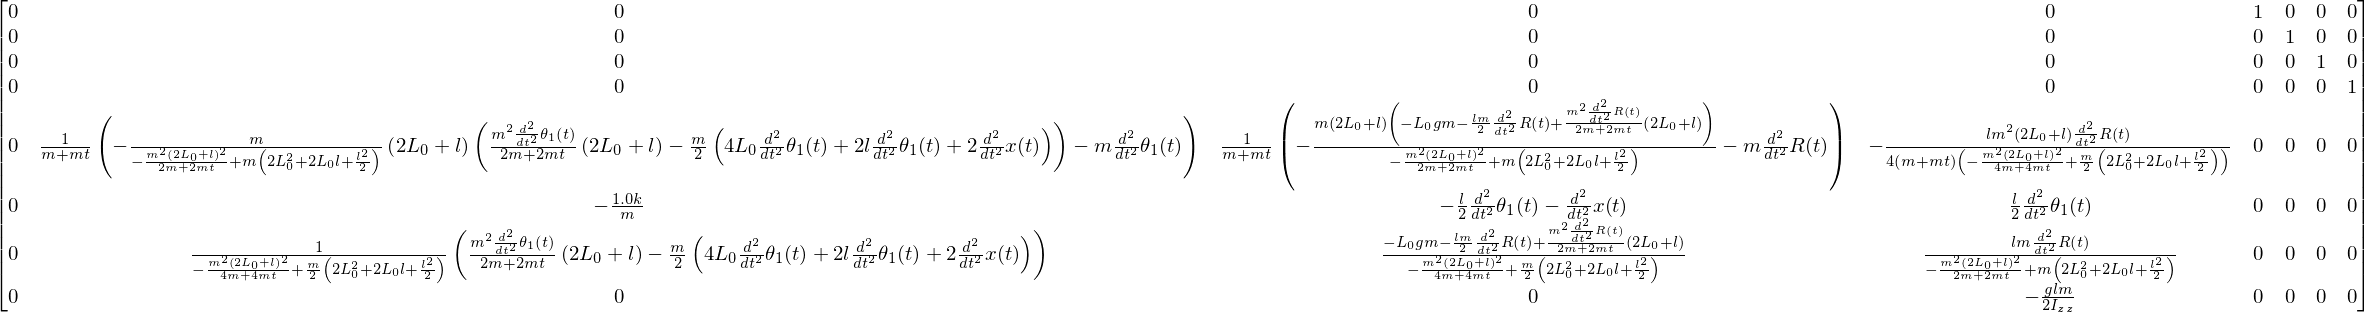

In [10]:
A

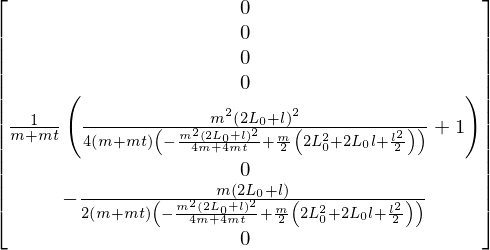

In [11]:
B

## Simulation
We can pass these equations of motion to numerical solver for simluation. To do so, we need to import [NumPy](http://numpy.org) and the [SciPy](http://www.scipy.org) ode solver, ```ode```. We'll also import [matplotlib](http://www.scipy.org) to enable plotting of the results.

For a system as simple as this one, we could easily set up the necessary components for the numerical simulation manually. However, here we will automate as much as possible. Following a similar procedure on more complicated systems would be necessary.

## Initial Conditions
The first task assigned was to simluate the response to the initial conditions $R(0) = L_0$, $\theta_2 = 15^\circ$, and all others equal to zero. The problem specifies that $x$ be fixed for this simluation, so we'll substitute that $\dot{x} = 0$ below. The $x=0$ condition can be captured via the simluation initial conditions.

In [12]:
# import NumPy with namespace np
import numpy as np

# import the scipy ODE solver
from scipy.integrate import ode

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

In [13]:
# define the forcing function
def force(t):
    # set the maximum force output
    fmax = 0.0
    
    # return a bang-bang command
    return fmax * (t > 0.5)

In [14]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6, w7, w8 = sympy.symbols('w1 w2 w3 w4 w5 w6 w7 w8', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t), w7(t), w8(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              R : w2(t),
              theta1: w3(t),
              theta2: w4(t),
              x_dot : 0,
              R_dot : w6(t),
              theta1_dot : w7(t), 
              theta2_dot : w8(t),
              m : 10.0,
              mt : 100.0,
              g : 9.81,
              l : 2.0,
              k : 500.0,
              l0 : 2.0,
              Izz : 1.0/12 * m * l**2,
              f: force(t)}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [15]:
# Set up the initial conditions for the solver
x_init = 0.0                    # Initial Trolley position (m)
x_dot_init = 0.0                # Initial trolley velocity (m/s)
R_init = 2.0                    # Initial spring length (m)
R_dot_init = 0.0                # Initial radial velocity (m/s)
theta1_init = 0.0 * np.pi/180  # Initial angle (rad)
theta1_dot_init = 0.0           # Initial angular velocity (rad/s)
theta2_init = 15.0 * np.pi/180  # Initial angle (rad)
theta2_dot_init = 0.0           # Initial angular velocity (rad/s)

# Pack the initial conditions into an array
x0 = [x_init, R_init, theta1_init, theta2_init, x_dot_init, R_dot_init, theta1_dot_init, theta2_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 30.0, 900) # 0-10s with 1001 points in between

In [16]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t <= (sim_time[-1] + 1e-9):
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

Now, let's plot the results. The second column of the ```response``` vector is the length of the spring, $R$, the third is angle of the spring, $\theta_1$, and the fourth is angle of the bar, $\theta_2$,. We first plot the trolley position, $x$, and the spring length, $R$ below. Then, we'll plot $\theta_1$ and $\theta_2$. In both cases, we spend more time setting up plotting parameters to make the plot more readable than actually plotting.

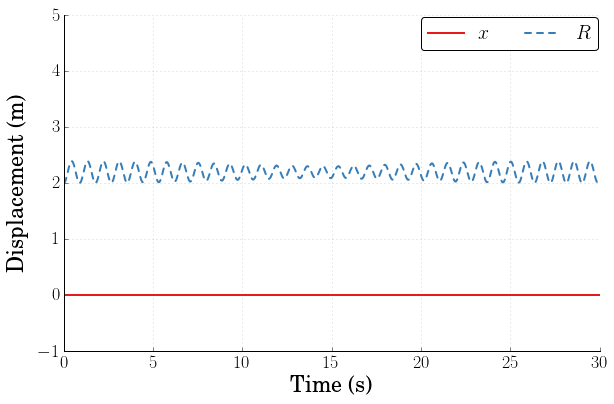

In [17]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Displacement (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='-', label = r'$x$')
plt.plot(sim_time, response[:, 1], linewidth=2, linestyle='--', label = r'$R$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(-1, 5)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_InitCondResponse_CartAndRadial.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

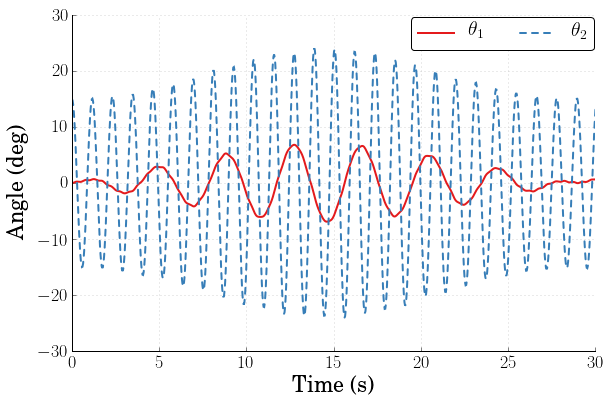

In [18]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 2] * 180/np.pi, linewidth=2, linestyle='-', label = r'$\theta_1$')
plt.plot(sim_time, response[:, 3] * 180/np.pi, linewidth=2, linestyle='--', label = r'$\theta_2$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(-30, 30)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_IntialCondResponse_Angles.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

We can maybe get a better understanding of the response by plotting a planar view of the endpoint motion over time. To do so, we need to define the $x$ and $y$ position of the the various points of the system, such as the spring attachment point, the bar center of mass, and the bar endpoint.

In [19]:
bar_length = 2.0

# Defines the position of the spring connection point in x-y
xp = response[:,0] + response[:,1] * np.sin(response[:,2])
yp = -response[:,1] * np.cos(response[:,2])

# The bar center of mass
xg = xp + bar_length/2 * np.sin(response[:,3] - response[:,2])
yg = yp - bar_length/2 * np.cos(response[:,3] - response[:,2])

# The bar low end
xend = xp + bar_length * np.sin(response[:,3] - response[:,2])
yend = yp - bar_length * np.cos(response[:,3] - response[:,2])

Now, let's plot those positions over time.

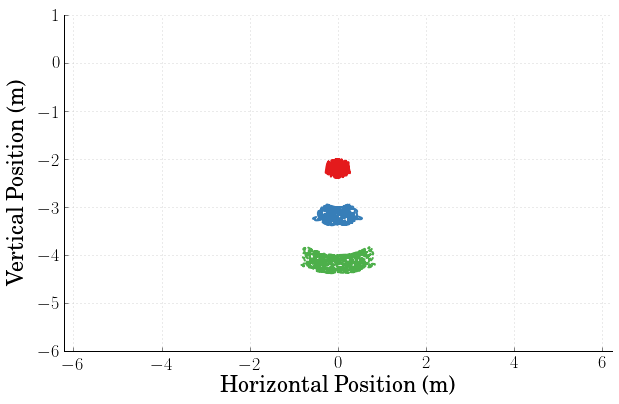

In [20]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Make the axes dimensions roughly equivalent
plt.ylim(-6, 1)
plt.xlim(-6.22, 6.22)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(xp, yp, linewidth=2, linestyle='-', label='P')
plt.plot(xg, yg, linewidth=2, linestyle='--', label='G')
plt.plot(xend, yend, linewidth=2, linestyle='-.', label='E')

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_InitCondResponse_Planar.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

Now, let's try to animate the response.

In [ ]:
import matplotlib.animation as animation

# Change some plot properties to make the video work and look better
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(8,4.5))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Create the lines to plot on the animation, they are empty for now
springLine, = plt.plot([],[], linewidth=2, linestyle = '-', label='Spring')
barLine, = plt.plot([],[], linewidth=6, linestyle = '-', label='Bar')

# Create the legend
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif', fontsize=16)

# Make the axes dimensions roughly equivalent
plt.ylim(-6, 1)
plt.xlim(-6.22, 6.22)

def init():
    """ Initialize the lines in the plot """
    springLine.set_data([], [])
    barLine.set_data([],[])
    
    return springLine, barLine,


def animate(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))
        
    springLine.set_data([response[i, 0], xp[i]], [0, yp[i]])
    barLine.set_data([xp[i], xend[i]], [yp[i], yend[i]])
    
    return springLine, barLine,

# Create the animation
ani = animation.FuncAnimation(fig, animate, interval = 30, frames = 900, blit = True, init_func = init)

# Uncomment the last line of this block to save the animation as an mp4.  
# This requires ffmpeg or mencoder to be installed.  
# The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# ani.save('SpringBar_Pendulum_InitCondResponse.mp4', bitrate = 2500, fps = 30)

# There is also the option to embed the movie into the notebook rather than save it as above
# Uncomment the lines below to do so.
# Notes:
#   * matplotlib 1.5 needed for this to work
#   * You'll likely need to change some of the plot parameters to make it look good
#
# from IPython.display import HTML
# HTML(ani.to_html5_video())

In [22]:
# Retutrn matplotlib defaults to default
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['savefig.bbox'] = 'tight'

## Forced Response
The next simluation required asks the response of the system starting from rest to a step input in force $f(t)$ at time $t=0.5$. We'll use a small force so that the response travels over a relatively small distance, allowing us to plot and animate the results again. Most of the code is identical to the initial condition case. We mainly just change the forcing function, return $\dot{x}$ to a nonzero value, and set the proper initial conditions.

In general, its bad practice to repeat so much code. This is, in my opinion, once of the major downsides to using this method of simluation with SymPy. The [PyDy](http://www.pydy.org) project appears to be addressing this by generating stand-alone simluation files that make reusing the code much easier.

In [23]:
# define the forcing function
def force(t):
    # set the maximum force output - small here for easy visualization
    fmax = 5.0
    
    # return a step command, amplitude fmax, starting at t = 0.5s
    return fmax * (t > 0.5)

In [24]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6, w7, w8 = sympy.symbols('w1 w2 w3 w4 w5 w6 w7 w8', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t), w7(t), w8(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              R : w2(t),
              theta1: w3(t),
              theta2: w4(t),
              x_dot : w5(t),
              R_dot : w6(t),
              theta1_dot : w7(t), 
              theta2_dot : w8(t),
              m : 10.0,
              mt : 100.0,
              g : 9.81,
              l : 2.0,
              k : 500.0,
              l0 : 2.0,
              Izz : 1.0/12 * m * l**2,
              f: force(t)}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

To set a true "at rest" equilibrium, we need to define the equilibrium spring length, where the graviational and spring forces balance. In this case, that occurs where:

$$ k(R - L_0) = m g $$

So, the spring length at equilibrium is then:

$$ R_{equil} = L_0 + \frac{m g}{k} $$

All other initial condiations are zero for this case.

In [25]:
x_init = 0.0                    # Initial Trolley position (m)
x_dot_init = 0.0                # Initial trolley velocity (m/s)

# chosen for static equil - spring and gravity forces balance
R_init = 2.0 + 10 * 9.81 / 500  # Initial spring length (m) - R0 = mg/k + L0

R_dot_init = 0.0                # Initial radial velocity (m/s)
theta1_init = 0.0 * np.pi/180   # Initial angle (rad)
theta1_dot_init = 0.0           # Initial angular velocity (rad/s)
theta2_init = 0.0 * np.pi/180   # Initial angle (rad)
theta2_dot_init = 0.0           # Initial angular velocity (rad/s)

# Pack the initial conditions into an array
x0 = [x_init, R_init, theta1_init, theta2_init, x_dot_init, R_dot_init, theta1_dot_init, theta2_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 30.0, 900) # 0-10s with 1001 points in between

In [26]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t <= (sim_time[-1] + 1e-9):
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

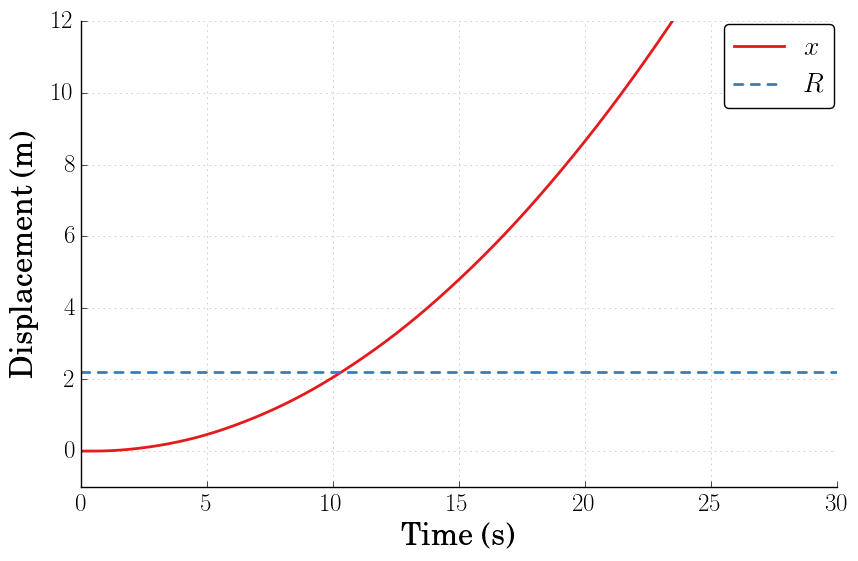

In [27]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Displacement (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='-', label = r'$x$')
plt.plot(sim_time, response[:, 1], linewidth=2, linestyle='--', label = r'$R$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(-1, 12)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_ForcedResponse_CartAndRadial.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

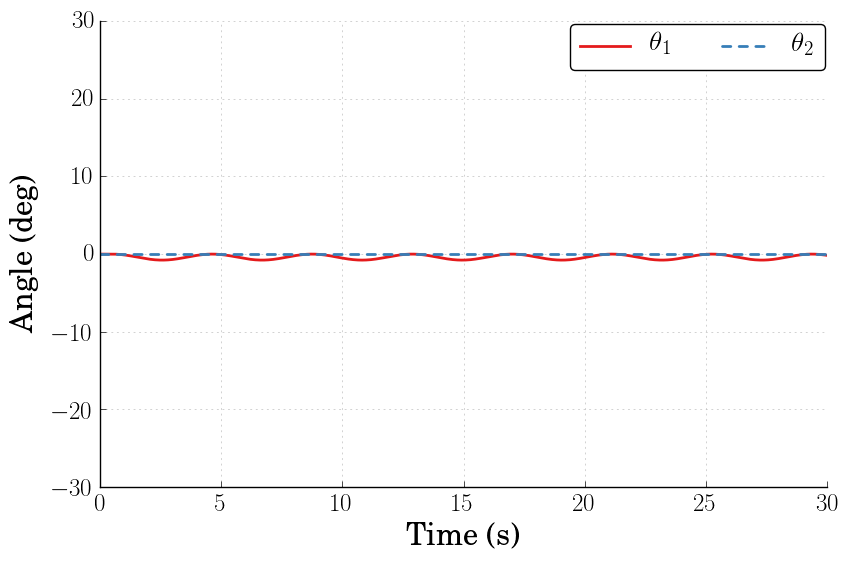

In [28]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 2] * 180/np.pi, linewidth=2, linestyle='-', label = r'$\theta_1$')
plt.plot(sim_time, response[:, 3] * 180/np.pi, linewidth=2, linestyle='--', label = r'$\theta_2$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
plt.ylim(-30, 30)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_ForcedResponse_Angles.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

In [29]:
bar_length = 2.0

# Defines the position of the spring connection point in x-y
xp = response[:,0] + response[:,1] * np.sin(response[:,2])
yp = -response[:,1] * np.cos(response[:,2])

# The bar center of mass
xg = xp + bar_length/2 * np.sin(response[:,3])
yg = yp - bar_length/2 * np.cos(response[:,3])

# The bar low end
xend = xp + bar_length * np.sin(response[:,3])
yend = yp - bar_length * np.cos(response[:,3])

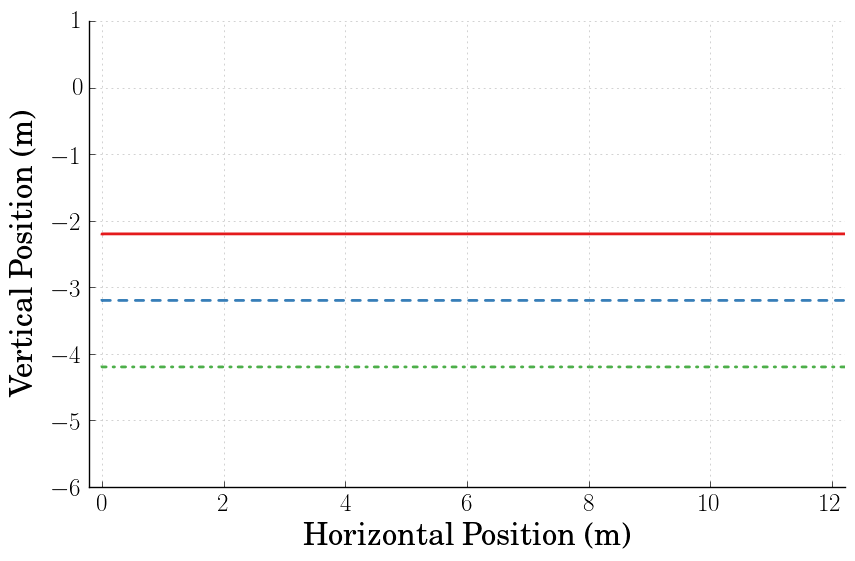

In [30]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Make the axes dimensions roughly equivalent
plt.ylim(-6, 1)
plt.xlim(-0.22, 12.22)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(xp, yp, linewidth=2, linestyle='-', label='P')
plt.plot(xg, yg, linewidth=2, linestyle='--', label='G')
plt.plot(xend, yend, linewidth=2, linestyle='-.', label='E')

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('SpringBar_Pendulum_ForcedResponse_Planar.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

In [ ]:
# Change some plot properties to make the video work and look better
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(8,4.5))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Create the lines to plot on the animation, they are empty for now
springLine, = plt.plot([],[], linewidth=2, linestyle = '-', label='Spring')
barLine, = plt.plot([],[], linewidth=6, linestyle = '-', label='Bar')

# Create the legend
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif', fontsize=16)

# Make the axes dimensions roughly equivalent
plt.ylim(-6, 1)
plt.xlim(-0.22, 12.22)

def init():
    """ Initialize the lines in the plot """
    springLine.set_data([], [])
    barLine.set_data([],[])
    
    return springLine, barLine,


def animate(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))
        
    springLine.set_data([response[i, 0], xp[i]], [0, yp[i]])
    barLine.set_data([xp[i], xend[i]], [yp[i], yend[i]])
    
    return springLine, barLine,

# Create the animation
ani = animation.FuncAnimation(fig, animate, interval = 30, frames = 900, blit = True, init_func = init)

# Uncomment the last line of this block to save the animation as an mp4.  
# This requires ffmpeg or mencoder to be installed.  
# The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# ani.save('SpringBar_Pendulum_ForcedResponse.mp4', bitrate = 2500, fps = 30)

# There is also the option to embed the movie into the notebook rather than save it as above
# Uncomment the lines below to do so.
# Notes:
#   * matplotlib 1.5 needed for this to work
#   * You'll likely need to change some of the plot parameters to make it look good
#
# from IPython.display import HTML
# HTML(ani.to_html5_video())

In [32]:
# Retutrn matplotlib defaults to default
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['savefig.bbox'] = 'tight'

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [33]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
import codecs
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(codecs.open(css_file, 'r', 'utf-8').read())